<a href="https://colab.research.google.com/github/Max-Ernst/Pokemon-Design-Synthesis/blob/main/Pokemon_Synthesis_maxernst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pokemon Design Synthesis

Max Ernst, maxernst

*Download Libraries*

In [ ]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchsummary import summary

from torchvision.datasets import ImageFolder
from tqdm import tqdm

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Using the GPU!


# *Load Dataset and Dataloader*

Dataset uploaded from local machine

In [ ]:
!unzip -q pokemon.zip

replace pokemon/pokemon/1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
image_dir = "/content/pokemon"

dataset_size = 2*819
image_size = 256
batch_size = 10

seed_size = 32

# Needed to normalize images in dataset
norm_vector = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denormalize(images):
  for i, input in enumerate(images):
    images[i] = images[i] * norm_vector[1][0] + norm_vector[0][0]
  
  return images

dataset = ImageFolder(image_dir, transform = transforms.Compose([transforms.Resize(image_size),
          transforms.CenterCrop(image_size),
          transforms.ToTensor(),
          transforms.Normalize(*norm_vector)]))

dataset_flipped = ImageFolder(image_dir, transform = transforms.Compose([transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(*norm_vector)]))

dataset = ConcatDataset([dataset, dataset_flipped])

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=False)


*Show Images From Dataset*

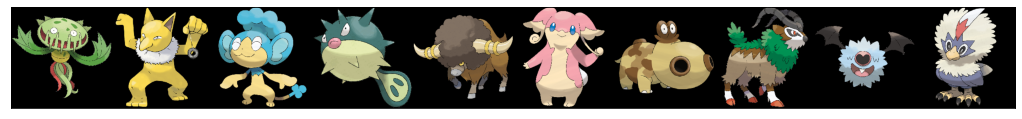

In [ ]:
# Show some images from the dataset
def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  inp = inp.numpy().transpose((1, 2, 0))
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Get a batch of training data
images, classes = next(iter(dataloader))

# Denormalize
images = denormalize(images)

# Make a grid from batch
out = torchvision.utils.make_grid(images, nrow=10)

fig, ax = plt.subplots(1, figsize=(18, 18))

imshow(out, ax=ax)

# *Build GAN*

In [ ]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std)
    m.bias.data.zero_()
    # delete end

*Generator*

In [ ]:
class Generator(nn.Module):
  # Initializers
  def __init__(self):
    super(Generator, self).__init__()

    network = []

    # Input is a seed of size seed_sizex1x1
    # Output is an image of 3x64x64
    # Layer 1
    network.append(nn.ConvTranspose2d(seed_size, 64, kernel_size=4, padding=1, stride=1))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(64, eps=0.0001))
    # Output 64x2x2

    # Layer 2
    network.append(nn.ConvTranspose2d(64, 128, kernel_size=4, padding=1, stride=2))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(128, eps=0.0001))
    # Output 128x4x4

    # Layer 3
    network.append(nn.ConvTranspose2d(128, 256, kernel_size=4, padding=1, stride=2))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(256, eps=0.0001))
    # Output 256x8x8

    # Layer 4
    network.append(nn.ConvTranspose2d(256, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    # Output 512x16x16

    # Layer 5
    network.append(nn.ConvTranspose2d(512, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    # Output 512x32x32

    # Layer 6
    network.append(nn.ConvTranspose2d(512, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    # Output 512x64x64

    # Layer 6
    network.append(nn.ConvTranspose2d(512, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    # Output 512x128x128

    # Layer 7
    network.append(nn.ConvTranspose2d(512, 512, kernel_size=5, padding=2, stride=1))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    # Output 512x128x128

    # Layer 8
    network.append(nn.ConvTranspose2d(512, 512, kernel_size=5, padding=2, stride=1))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    # Output 512x128x128

    # Layer 9
    network.append(nn.ConvTranspose2d(512, 3, kernel_size=4, padding=1, stride=2))
    # Output 3x256x256

    self.generator = nn.Sequential(*network)
    
  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)
  
  def forward(self, input):
    output = self.generator(input)
    
    return output

generator = Generator()

*Discriminator*

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    network = []

    # Input is 3x256x256
    # Output is True/False, so 1x1x1
    # Layer 1
    network.append(nn.Conv2d(3, 64, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(64, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Output 64x128x128
    
    # Layer 2
    network.append(nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(128, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Output 128x64x64

    # Layer 3
    network.append(nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(256, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Ouput 256x32x32

    # Layer 4
    network.append(nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Output 512x16x16

    # Layer 5
    network.append(nn.Conv2d(512, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Output 512x8x8

    # Layer 6
    network.append(nn.Conv2d(512, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Output 512x4x4

    # Layer 7
    network.append(nn.Conv2d(512, 512, kernel_size=4, padding=1, stride=2))
    network.append(nn.BatchNorm2d(512, eps=0.0001))
    network.append(nn.LeakyReLU(negative_slope=0.1))
    # Output 512x2x2

    # Layer 8
    network.append(nn.Conv2d(512, 1, kernel_size=4, padding=1, stride=1))
    # Output 1x1x1

    self.discriminator = nn.Sequential(*network)

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)
      
  def forward(self, input):

    output = self.discriminator(input)

    output = torch.sigmoid(output)

    return output

*Summarize Networks*

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)
summary(gen, (seed_size, 1, 1))
summary(disc, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 64, 2, 2]          32,832
         LeakyReLU-2             [-1, 64, 2, 2]               0
       BatchNorm2d-3             [-1, 64, 2, 2]             128
   ConvTranspose2d-4            [-1, 128, 4, 4]         131,200
         LeakyReLU-5            [-1, 128, 4, 4]               0
       BatchNorm2d-6            [-1, 128, 4, 4]             256
   ConvTranspose2d-7            [-1, 256, 8, 8]         524,544
         LeakyReLU-8            [-1, 256, 8, 8]               0
       BatchNorm2d-9            [-1, 256, 8, 8]             512
  ConvTranspose2d-10          [-1, 512, 16, 16]       2,097,664
        LeakyReLU-11          [-1, 512, 16, 16]               0
      BatchNorm2d-12          [-1, 512, 16, 16]           1,024
  ConvTranspose2d-13          [-1, 512, 32, 32]       4,194,816
        LeakyReLU-14          [-1, 512,

In [ ]:
gen

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1)
    (11): BatchNorm2d(512, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Lea

In [ ]:
disc

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.1)
    (12): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=0.0001, momentum=0.1

# *Train Network*

In [ ]:
def train(generator, discriminator, optimizer="ADAMW", loss="BCE", learning_rate=0.003, num_epochs=20):
  torch.cuda.empty_cache()

  g_loss_history = []
  d_loss_history = []

  if loss=="BCE":
    loss_func = nn.BCELoss().to(device)
  if loss=="MSE":
    loss_func = nn.MSELoss().to(device)
  if optimizer=="ADAMW":
    g_optim = optim.AdamW(generator.parameters(), lr=learning_rate, betas=[0.5, 0.999])
    d_optim = optim.AdamW(discriminator.parameters(), lr=learning_rate, betas=[0.5, 0.999])
  if optimizer=="ADAM":
    g_optim = optim.Adam(generator.parameters(), lr=learning_rate, betas=[0.5, 0.999])
    d_optim = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=[0.5, 0.999])
  if optimizer=="SGD":
    g_optim = optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.001, weight_decay=0.00001)
    d_optim = optim.SGD(discriminator.parameters(), lr=learning_rate, momentum=0.001, weight_decay=0.00001)
  if optimizer=="ADAGRAD":
    g_optim = optim.Adagrad(generator.parameters())
    d_optim = optim.Adagrad(discriminator.parameters())
  
  print('Starting Training!')

  epoch_start_time = time.time()

  for epoch in range(num_epochs):
    print('Beginning Epoch', epoch+1)

    for batch, _ in tqdm(dataloader):
      batch = batch.to(device)

      discriminator.zero_grad()
      generator.zero_grad()

      # Train Discriminator
      seed = torch.randn(batch_size, seed_size, 1, 1, device=device)
      fakemon = gen(seed)[0:batch.shape[0]]

      fakemon_predictions = disc(fakemon).flatten()
      fakemon_targets = torch.ones(fakemon.shape[0]).to(device)
      fakemon_loss = loss_func(fakemon_predictions, fakemon_targets)

      realmon_predictions = disc(batch).flatten()
      realmon_targets = torch.zeros(batch.shape[0]).to(device)
      realmon_loss = loss_func(realmon_predictions, realmon_targets)

      disc_loss = (fakemon_loss + realmon_loss)

      d_loss_history.append(disc_loss.detach().item())

      disc_loss.backward()
      d_optim.step()

      # Train Generator
      seed = torch.randn(batch_size, seed_size, 1, 1, device=device)
      fakemon = gen(seed)[0:batch.shape[0]]
      fakemon_predictions = disc(fakemon).flatten()
      gen_targets = torch.zeros(fakemon.shape[0]).to(device)

      gen_loss_pokemon = F.binary_cross_entropy_with_logits(fakemon, batch) / 30
      gen_loss_disc = loss_func(fakemon_predictions, gen_targets)
      gen_loss = (gen_loss_pokemon + gen_loss_disc) / 2

      g_loss_history.append(gen_loss.detach().item())

      gen_loss.backward()
      g_optim.step()

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time
    
    print('Epoch [%d/%d] - Current Training Time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
    print('loss of discriminator D: %.3f' % (torch.mean(torch.FloatTensor(d_loss_history))))
    print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(g_loss_history))))
    
    if epoch == 0 or (epoch + 1) % 10 == 0:
      realmon, classes = next(iter(dataloader))
      realmon = realmon.to(device)

      seed = torch.randn(batch_size, seed_size, 1, 1, device=device)
      fakemon = gen(seed)

      fakemon_preds = disc(fakemon)
      fakemon_titles = []

      for pred in fakemon_preds:
        if round(pred.item()) == 1:
          fakemon_titles.append("Fake")
        else:
          fakemon_titles.append("Real")

      realmon_preds = disc(realmon)
      realmon_titles = []
      for pred in realmon_preds:
        if round(pred.item()) == 1:
          realmon_titles.append("Fake")
        else:
          realmon_titles.append("Real")

      realmon = denormalize(realmon.cpu())
      fakemon = denormalize(fakemon.cpu())

      fakemon_grid = torchvision.utils.make_grid(fakemon, nrow=10).cpu().numpy().transpose((1, 2, 0))
      realmon_grid = torchvision.utils.make_grid(realmon, nrow=10).cpu().numpy().transpose((1, 2, 0))

      fig, ax = plt.subplots(1, figsize=(18,18))
      ax.imshow(realmon_grid)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_title(realmon_titles)

      fig, ax = plt.subplots(1, figsize=(18,18))
      ax.imshow(fakemon_grid)
      ax.set_xticks([])
      ax.set_yticks([])
      ax.set_title(fakemon_titles)

      plt.show()

  return d_loss_history, g_loss_history

*Train on LR=0.0001, ADAM Optimizer, BCE Loss*

Starting Training!
Beginning Epoch 1


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]

Epoch [1/50] - Current Training Time: 49.99 seconds
loss of discriminator D: 0.257
loss of generator G: 1.900


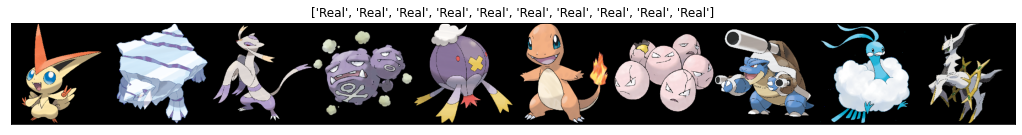

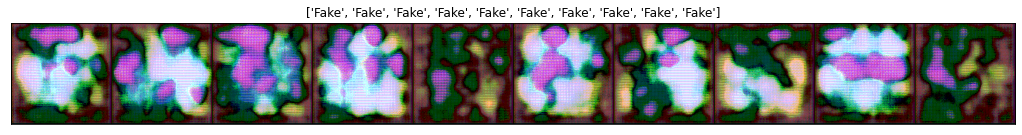

Beginning Epoch 2


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [2/50] - Current Training Time: 100.64 seconds
loss of discriminator D: 0.244
loss of generator G: 2.156
Beginning Epoch 3


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [3/50] - Current Training Time: 150.56 seconds
loss of discriminator D: 0.209
loss of generator G: 2.238
Beginning Epoch 4


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [4/50] - Current Training Time: 200.49 seconds
loss of discriminator D: 0.192
loss of generator G: 2.282
Beginning Epoch 5


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [5/50] - Current Training Time: 250.42 seconds
loss of discriminator D: 0.213
loss of generator G: 2.302
Beginning Epoch 6


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [6/50] - Current Training Time: 300.37 seconds
loss of discriminator D: 0.214
loss of generator G: 2.273
Beginning Epoch 7


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [7/50] - Current Training Time: 350.25 seconds
loss of discriminator D: 0.212
loss of generator G: 2.263
Beginning Epoch 8


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [8/50] - Current Training Time: 400.23 seconds
loss of discriminator D: 0.215
loss of generator G: 2.229
Beginning Epoch 9


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [9/50] - Current Training Time: 450.20 seconds
loss of discriminator D: 0.214
loss of generator G: 2.246
Beginning Epoch 10


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]

Epoch [10/50] - Current Training Time: 500.13 seconds
loss of discriminator D: 0.206
loss of generator G: 2.257


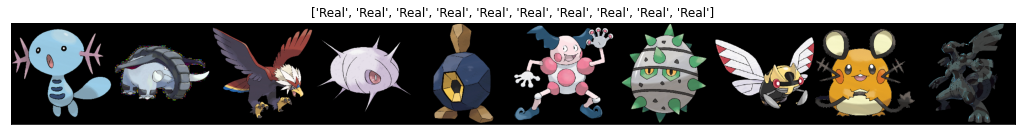

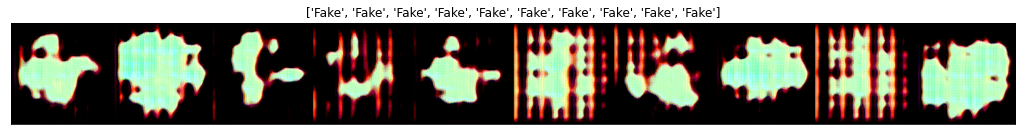

Beginning Epoch 11


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [11/50] - Current Training Time: 550.75 seconds
loss of discriminator D: 0.211
loss of generator G: 2.228
Beginning Epoch 12


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [12/50] - Current Training Time: 600.61 seconds
loss of discriminator D: 0.213
loss of generator G: 2.205
Beginning Epoch 13


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [13/50] - Current Training Time: 650.52 seconds
loss of discriminator D: 0.231
loss of generator G: 2.157
Beginning Epoch 14


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [14/50] - Current Training Time: 700.39 seconds
loss of discriminator D: 0.242
loss of generator G: 2.176
Beginning Epoch 15


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [15/50] - Current Training Time: 750.27 seconds
loss of discriminator D: 0.248
loss of generator G: 2.134
Beginning Epoch 16


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [16/50] - Current Training Time: 800.21 seconds
loss of discriminator D: 0.243
loss of generator G: 2.134
Beginning Epoch 17


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [17/50] - Current Training Time: 850.15 seconds
loss of discriminator D: 0.234
loss of generator G: 2.168
Beginning Epoch 18


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [18/50] - Current Training Time: 900.06 seconds
loss of discriminator D: 0.229
loss of generator G: 2.161
Beginning Epoch 19


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [19/50] - Current Training Time: 949.97 seconds
loss of discriminator D: 0.238
loss of generator G: 2.145
Beginning Epoch 20


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]

Epoch [20/50] - Current Training Time: 999.88 seconds
loss of discriminator D: 0.234
loss of generator G: 2.139


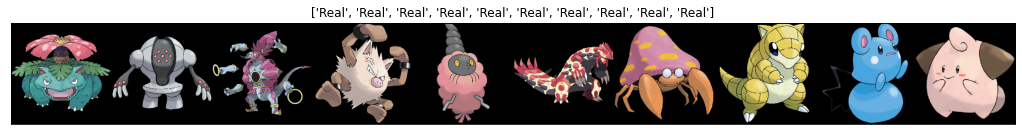

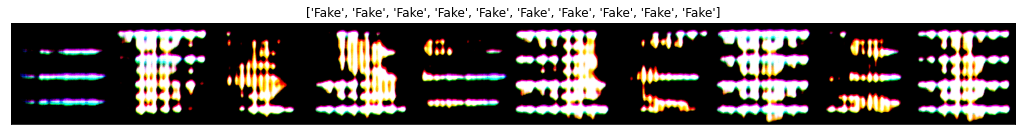

Beginning Epoch 21


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [21/50] - Current Training Time: 1050.55 seconds
loss of discriminator D: 0.247
loss of generator G: 2.110
Beginning Epoch 22


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [22/50] - Current Training Time: 1100.47 seconds
loss of discriminator D: 0.250
loss of generator G: 2.093
Beginning Epoch 23


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [23/50] - Current Training Time: 1150.40 seconds
loss of discriminator D: 0.249
loss of generator G: 2.080
Beginning Epoch 24


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [24/50] - Current Training Time: 1200.41 seconds
loss of discriminator D: 0.242
loss of generator G: 2.089
Beginning Epoch 25


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [25/50] - Current Training Time: 1250.38 seconds
loss of discriminator D: 0.249
loss of generator G: 2.073
Beginning Epoch 26


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [26/50] - Current Training Time: 1300.34 seconds
loss of discriminator D: 0.255
loss of generator G: 2.054
Beginning Epoch 27


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [27/50] - Current Training Time: 1350.33 seconds
loss of discriminator D: 0.252
loss of generator G: 2.051
Beginning Epoch 28


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [28/50] - Current Training Time: 1400.22 seconds
loss of discriminator D: 0.251
loss of generator G: 2.061
Beginning Epoch 29


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [29/50] - Current Training Time: 1450.14 seconds
loss of discriminator D: 0.253
loss of generator G: 2.046
Beginning Epoch 30


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]

Epoch [30/50] - Current Training Time: 1500.05 seconds
loss of discriminator D: 0.250
loss of generator G: 2.056


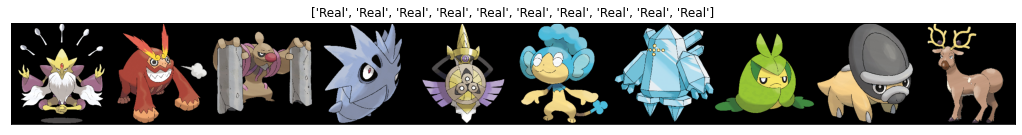

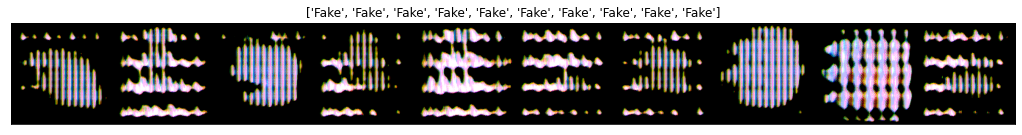

Beginning Epoch 31


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [31/50] - Current Training Time: 1550.63 seconds
loss of discriminator D: 0.247
loss of generator G: 2.065
Beginning Epoch 32


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]


Epoch [32/50] - Current Training Time: 1600.68 seconds
loss of discriminator D: 0.247
loss of generator G: 2.069
Beginning Epoch 33


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [33/50] - Current Training Time: 1650.68 seconds
loss of discriminator D: 0.246
loss of generator G: 2.066
Beginning Epoch 34


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [34/50] - Current Training Time: 1700.68 seconds
loss of discriminator D: 0.242
loss of generator G: 2.075
Beginning Epoch 35


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [35/50] - Current Training Time: 1750.67 seconds
loss of discriminator D: 0.240
loss of generator G: 2.086
Beginning Epoch 36


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [36/50] - Current Training Time: 1800.60 seconds
loss of discriminator D: 0.240
loss of generator G: 2.100
Beginning Epoch 37


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [37/50] - Current Training Time: 1850.56 seconds
loss of discriminator D: 0.239
loss of generator G: 2.111
Beginning Epoch 38


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [38/50] - Current Training Time: 1900.53 seconds
loss of discriminator D: 0.237
loss of generator G: 2.119
Beginning Epoch 39


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [39/50] - Current Training Time: 1950.43 seconds
loss of discriminator D: 0.232
loss of generator G: 2.121
Beginning Epoch 40


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]

Epoch [40/50] - Current Training Time: 2000.48 seconds
loss of discriminator D: 0.238
loss of generator G: 2.110


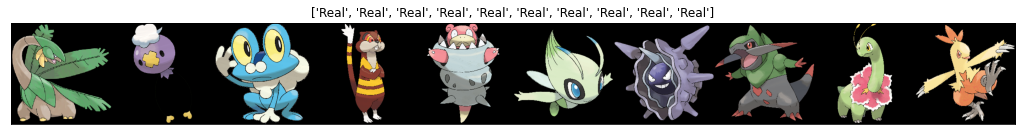

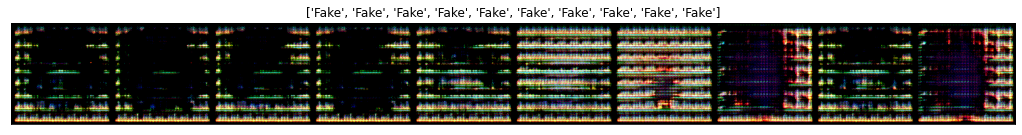

Beginning Epoch 41


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [41/50] - Current Training Time: 2051.21 seconds
loss of discriminator D: 0.237
loss of generator G: 2.106
Beginning Epoch 42


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [42/50] - Current Training Time: 2101.19 seconds
loss of discriminator D: 0.234
loss of generator G: 2.109
Beginning Epoch 43


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [43/50] - Current Training Time: 2151.16 seconds
loss of discriminator D: 0.240
loss of generator G: 2.105
Beginning Epoch 44


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [44/50] - Current Training Time: 2201.09 seconds
loss of discriminator D: 0.241
loss of generator G: 2.096
Beginning Epoch 45


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [45/50] - Current Training Time: 2251.08 seconds
loss of discriminator D: 0.242
loss of generator G: 2.098
Beginning Epoch 46


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [46/50] - Current Training Time: 2301.02 seconds
loss of discriminator D: 0.241
loss of generator G: 2.088
Beginning Epoch 47


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]


Epoch [47/50] - Current Training Time: 2350.92 seconds
loss of discriminator D: 0.240
loss of generator G: 2.090
Beginning Epoch 48


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]


Epoch [48/50] - Current Training Time: 2400.96 seconds
loss of discriminator D: 0.242
loss of generator G: 2.082
Beginning Epoch 49


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [49/50] - Current Training Time: 2450.94 seconds
loss of discriminator D: 0.246
loss of generator G: 2.079
Beginning Epoch 50


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]

Epoch [50/50] - Current Training Time: 2500.97 seconds
loss of discriminator D: 0.249
loss of generator G: 2.067


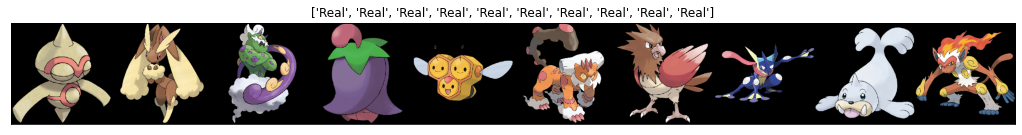

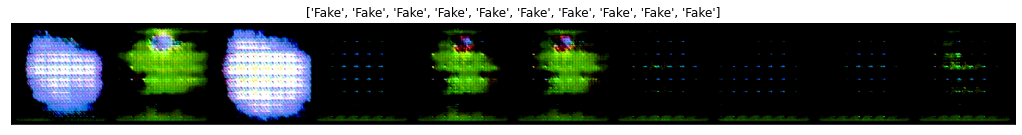

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)
gen.weight_init(mean=0.0, std=0.01)
disc.weight_init(mean=0.0, std=0.01)
gen.train()
disc.train()

num_epochs = 50
optimizer = "ADAM"
loss_func = "BCE"

d_loss, g_loss = train(gen, disc, optimizer, loss_func, learning_rate=0.0001, num_epochs=num_epochs)
torch.save(gen.state_dict(), 'gen_test1.pth')

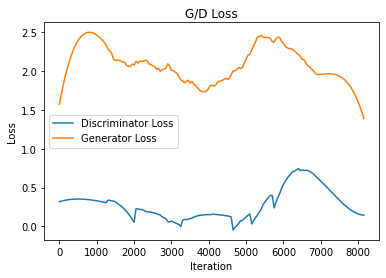

In [ ]:
from scipy.signal import savgol_filter

x = np.arange(0,num_epochs*(dataset_size/batch_size),50)

plt.figure()

# Smooth out the data
d_y = savgol_filter(torch.tensor(d_loss, device='cpu')[x], 51, 3)
g_y = savgol_filter(torch.tensor(g_loss, device='cpu')[x], 51, 3)

plt.plot(x, d_y)
plt.plot(x, g_y)

plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.xticks(np.arange(0,num_epochs*(dataset_size/batch_size),1000))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('G/D Loss')
plt.show()

*Train on LR=0.0001, ADAM Optimizer, MSE Loss*

Starting Training!
Beginning Epoch 1


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]

Epoch [1/25] - Current Training Time: 50.21 seconds
loss of discriminator D: 0.052
loss of generator G: 0.481


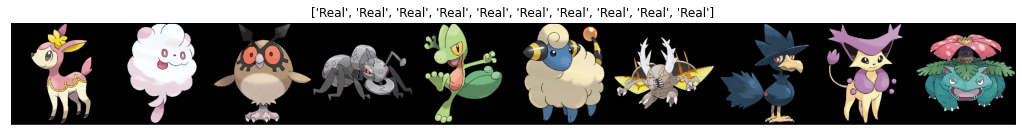

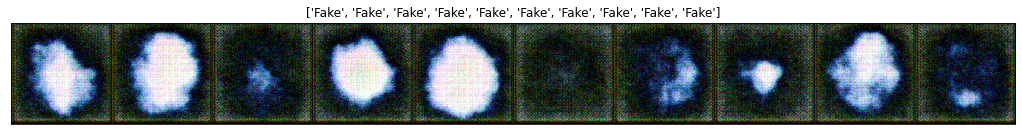

Beginning Epoch 2


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [2/25] - Current Training Time: 101.39 seconds
loss of discriminator D: 0.033
loss of generator G: 0.474
Beginning Epoch 3


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [3/25] - Current Training Time: 151.81 seconds
loss of discriminator D: 0.030
loss of generator G: 0.477
Beginning Epoch 4


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [4/25] - Current Training Time: 202.28 seconds
loss of discriminator D: 0.024
loss of generator G: 0.479
Beginning Epoch 5


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [5/25] - Current Training Time: 252.76 seconds
loss of discriminator D: 0.019
loss of generator G: 0.479
Beginning Epoch 6


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [6/25] - Current Training Time: 303.24 seconds
loss of discriminator D: 0.017
loss of generator G: 0.478
Beginning Epoch 7


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [7/25] - Current Training Time: 353.74 seconds
loss of discriminator D: 0.015
loss of generator G: 0.476
Beginning Epoch 8


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [8/25] - Current Training Time: 404.01 seconds
loss of discriminator D: 0.013
loss of generator G: 0.473
Beginning Epoch 9


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [9/25] - Current Training Time: 454.29 seconds
loss of discriminator D: 0.012
loss of generator G: 0.470
Beginning Epoch 10


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]

Epoch [10/25] - Current Training Time: 504.59 seconds
loss of discriminator D: 0.011
loss of generator G: 0.465


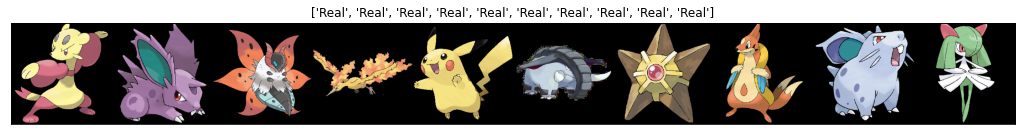

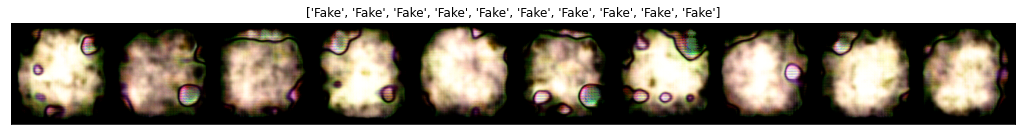

Beginning Epoch 11


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [11/25] - Current Training Time: 555.85 seconds
loss of discriminator D: 0.010
loss of generator G: 0.458
Beginning Epoch 12


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [12/25] - Current Training Time: 606.38 seconds
loss of discriminator D: 0.009
loss of generator G: 0.450
Beginning Epoch 13


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [13/25] - Current Training Time: 656.86 seconds
loss of discriminator D: 0.008
loss of generator G: 0.440
Beginning Epoch 14


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [14/25] - Current Training Time: 707.33 seconds
loss of discriminator D: 0.008
loss of generator G: 0.428
Beginning Epoch 15


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [15/25] - Current Training Time: 757.70 seconds
loss of discriminator D: 0.007
loss of generator G: 0.412
Beginning Epoch 16


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [16/25] - Current Training Time: 808.20 seconds
loss of discriminator D: 0.007
loss of generator G: 0.392
Beginning Epoch 17


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [17/25] - Current Training Time: 858.60 seconds
loss of discriminator D: 0.006
loss of generator G: 0.368
Beginning Epoch 18


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [18/25] - Current Training Time: 909.01 seconds
loss of discriminator D: 0.006
loss of generator G: 0.338
Beginning Epoch 19


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [19/25] - Current Training Time: 959.40 seconds
loss of discriminator D: 0.006
loss of generator G: 0.303
Beginning Epoch 20


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]

Epoch [20/25] - Current Training Time: 1009.80 seconds
loss of discriminator D: 0.005
loss of generator G: 0.261


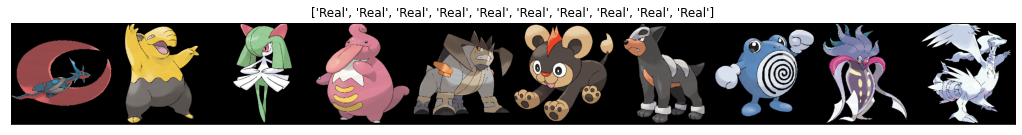

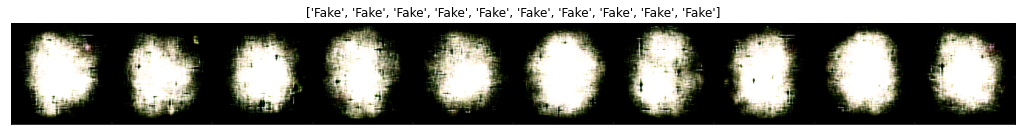

Beginning Epoch 21


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [21/25] - Current Training Time: 1060.86 seconds
loss of discriminator D: 0.005
loss of generator G: 0.213
Beginning Epoch 22


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [22/25] - Current Training Time: 1111.24 seconds
loss of discriminator D: 0.005
loss of generator G: 0.158
Beginning Epoch 23


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [23/25] - Current Training Time: 1161.62 seconds
loss of discriminator D: 0.005
loss of generator G: 0.094
Beginning Epoch 24


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [24/25] - Current Training Time: 1211.99 seconds
loss of discriminator D: 0.004
loss of generator G: 0.022
Beginning Epoch 25


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [25/25] - Current Training Time: 1262.35 seconds
loss of discriminator D: 0.004
loss of generator G: -0.058


In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)
gen.weight_init(mean=0.0, std=0.001)
disc.weight_init(mean=0.0, std=0.001)
gen.train()
disc.train()

num_epochs = 30
optimizer = "ADAM"
loss_func = "MSE"

d_loss, g_loss = train(gen, disc, optimizer, loss_func, learning_rate=0.0001, num_epochs=num_epochs)
torch.save(gen.state_dict(), 'gen_test2.pth')

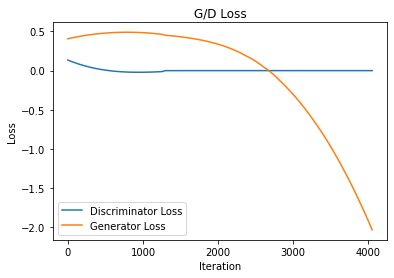

In [ ]:
x = np.arange(0,num_epochs*(dataset_size/batch_size),50)

plt.figure()

# Smooth out the data
d_y = savgol_filter(torch.tensor(d_loss, device='cpu')[x], 51, 3)
g_y = savgol_filter(torch.tensor(g_loss, device='cpu')[x], 51, 3)

plt.plot(x, d_y)
plt.plot(x, g_y)

plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.xticks(np.arange(0,num_epochs*(dataset_size/batch_size),1000))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('G/D Loss')
plt.show()

*Train on LR=0.001, ADAMW Optimizer, BCE Loss*

Starting Training!
Beginning Epoch 1


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]

Epoch [1/30] - Current Training Time: 50.16 seconds
loss of discriminator D: 0.307
loss of generator G: 1.899


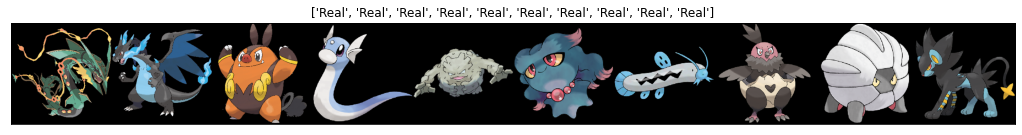

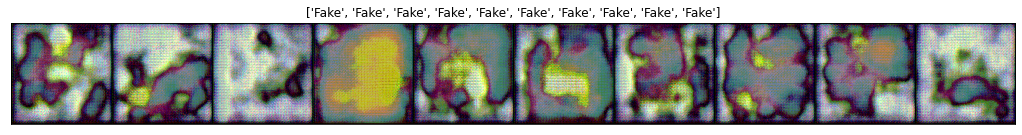

Beginning Epoch 2


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [2/30] - Current Training Time: 101.14 seconds
loss of discriminator D: 0.285
loss of generator G: 2.014
Beginning Epoch 3


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [3/30] - Current Training Time: 151.46 seconds
loss of discriminator D: 0.305
loss of generator G: 1.934
Beginning Epoch 4


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [4/30] - Current Training Time: 201.79 seconds
loss of discriminator D: 0.244
loss of generator G: 2.069
Beginning Epoch 5


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [5/30] - Current Training Time: 252.13 seconds
loss of discriminator D: 0.275
loss of generator G: 2.031
Beginning Epoch 6


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [6/30] - Current Training Time: 302.44 seconds
loss of discriminator D: 0.281
loss of generator G: 2.014
Beginning Epoch 7


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [7/30] - Current Training Time: 352.76 seconds
loss of discriminator D: 0.290
loss of generator G: 1.989
Beginning Epoch 8


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [8/30] - Current Training Time: 403.14 seconds
loss of discriminator D: 0.312
loss of generator G: 1.912
Beginning Epoch 9


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [9/30] - Current Training Time: 453.50 seconds
loss of discriminator D: 0.309
loss of generator G: 1.892
Beginning Epoch 10


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]

Epoch [10/30] - Current Training Time: 503.84 seconds
loss of discriminator D: 0.307
loss of generator G: 1.901


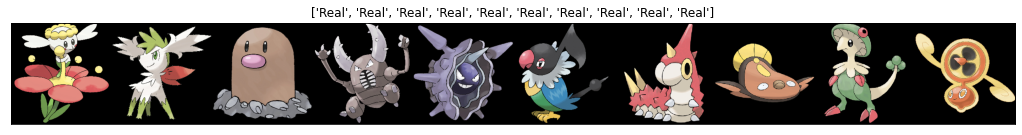

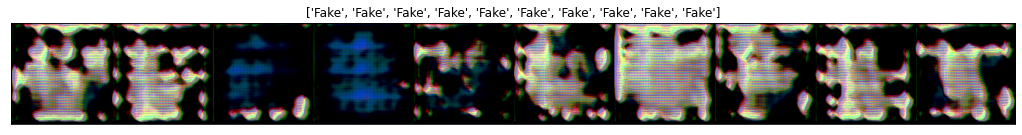

Beginning Epoch 11


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [11/30] - Current Training Time: 554.90 seconds
loss of discriminator D: 0.281
loss of generator G: 1.945
Beginning Epoch 12


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [12/30] - Current Training Time: 605.29 seconds
loss of discriminator D: 0.276
loss of generator G: 1.976
Beginning Epoch 13


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [13/30] - Current Training Time: 655.66 seconds
loss of discriminator D: 0.265
loss of generator G: 2.002
Beginning Epoch 14


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [14/30] - Current Training Time: 706.05 seconds
loss of discriminator D: 0.250
loss of generator G: 2.051
Beginning Epoch 15


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [15/30] - Current Training Time: 756.46 seconds
loss of discriminator D: 0.261
loss of generator G: 2.062
Beginning Epoch 16


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [16/30] - Current Training Time: 806.83 seconds
loss of discriminator D: 0.257
loss of generator G: 2.047
Beginning Epoch 17


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [17/30] - Current Training Time: 857.21 seconds
loss of discriminator D: 0.248
loss of generator G: 2.086
Beginning Epoch 18


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [18/30] - Current Training Time: 907.59 seconds
loss of discriminator D: 0.251
loss of generator G: 2.074
Beginning Epoch 19


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [19/30] - Current Training Time: 957.99 seconds
loss of discriminator D: 0.252
loss of generator G: 2.067
Beginning Epoch 20


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]

Epoch [20/30] - Current Training Time: 1008.36 seconds
loss of discriminator D: 0.257
loss of generator G: 2.060


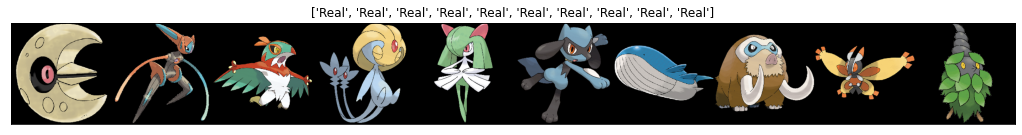

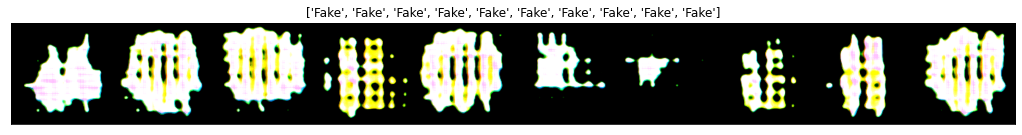

Beginning Epoch 21


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [21/30] - Current Training Time: 1059.31 seconds
loss of discriminator D: 0.259
loss of generator G: 2.050
Beginning Epoch 22


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [22/30] - Current Training Time: 1109.68 seconds
loss of discriminator D: 0.258
loss of generator G: 2.050
Beginning Epoch 23


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [23/30] - Current Training Time: 1160.01 seconds
loss of discriminator D: 0.263
loss of generator G: 2.035
Beginning Epoch 24


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [24/30] - Current Training Time: 1210.37 seconds
loss of discriminator D: 0.256
loss of generator G: 2.035
Beginning Epoch 25


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [25/30] - Current Training Time: 1260.78 seconds
loss of discriminator D: 0.251
loss of generator G: 2.044
Beginning Epoch 26


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [26/30] - Current Training Time: 1311.19 seconds
loss of discriminator D: 0.252
loss of generator G: 2.043
Beginning Epoch 27


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [27/30] - Current Training Time: 1361.59 seconds
loss of discriminator D: 0.259
loss of generator G: 2.032
Beginning Epoch 28


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]


Epoch [28/30] - Current Training Time: 1411.96 seconds
loss of discriminator D: 0.253
loss of generator G: 2.041
Beginning Epoch 29


100%|██████████| 164/164 [00:50<00:00,  3.25it/s]


Epoch [29/30] - Current Training Time: 1462.35 seconds
loss of discriminator D: 0.247
loss of generator G: 2.058
Beginning Epoch 30


100%|██████████| 164/164 [00:50<00:00,  3.26it/s]

Epoch [30/30] - Current Training Time: 1512.71 seconds
loss of discriminator D: 0.245
loss of generator G: 2.074


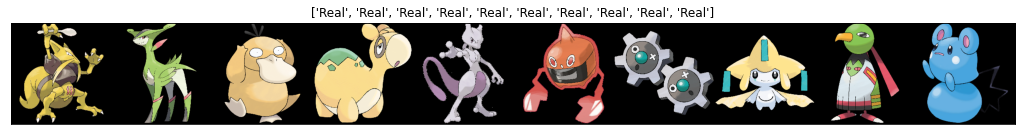

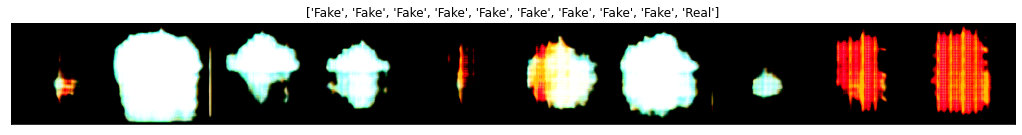

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)
gen.weight_init(mean=0.0, std=0.01)
disc.weight_init(mean=0.0, std=0.01)
gen.train()
disc.train()

num_epochs = 30
optimizer = "ADAMW"
loss_func = "BCE"

d_loss, g_loss = train(gen, disc, optimizer, loss_func, learning_rate=0.001, num_epochs=num_epochs)
torch.save(gen.state_dict(), 'gen_test3.pth')

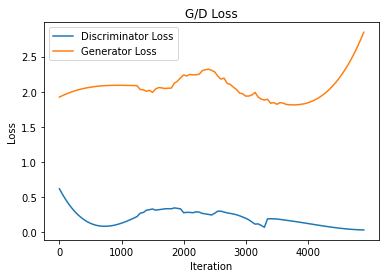

In [ ]:
x = np.arange(0,num_epochs*(dataset_size/batch_size),50)

plt.figure()

# Smooth out the data
d_y = savgol_filter(torch.tensor(d_loss, device='cpu')[x], 51, 3)
g_y = savgol_filter(torch.tensor(g_loss, device='cpu')[x], 51, 3)

plt.plot(x, d_y)
plt.plot(x, g_y)

plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.xticks(np.arange(0,num_epochs*(dataset_size/batch_size),1000))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('G/D Loss')
plt.show()

*Train on LR=0.003, ADAGRAD Optimizer, BCE Loss*

Starting Training!
Beginning Epoch 1


100%|██████████| 164/164 [00:49<00:00,  3.29it/s]

Epoch [1/50] - Current Training Time: 49.80 seconds
loss of discriminator D: 0.693
loss of generator G: 1.456


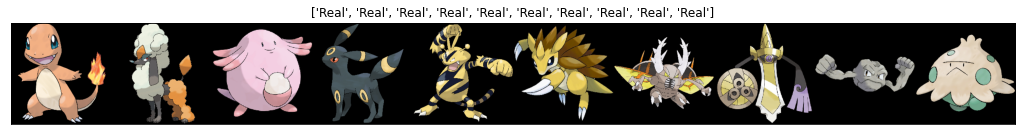

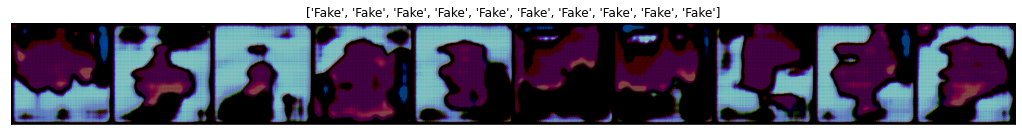

Beginning Epoch 2


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [2/50] - Current Training Time: 100.52 seconds
loss of discriminator D: 0.641
loss of generator G: 1.458
Beginning Epoch 3


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [3/50] - Current Training Time: 150.47 seconds
loss of discriminator D: 0.607
loss of generator G: 1.364
Beginning Epoch 4


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [4/50] - Current Training Time: 200.43 seconds
loss of discriminator D: 0.556
loss of generator G: 1.406
Beginning Epoch 5


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [5/50] - Current Training Time: 250.42 seconds
loss of discriminator D: 0.504
loss of generator G: 1.447
Beginning Epoch 6


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [6/50] - Current Training Time: 300.57 seconds
loss of discriminator D: 0.522
loss of generator G: 1.398
Beginning Epoch 7


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [7/50] - Current Training Time: 350.72 seconds
loss of discriminator D: 0.503
loss of generator G: 1.362
Beginning Epoch 8


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [8/50] - Current Training Time: 400.87 seconds
loss of discriminator D: 0.482
loss of generator G: 1.338
Beginning Epoch 9


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [9/50] - Current Training Time: 451.01 seconds
loss of discriminator D: 0.442
loss of generator G: 1.347
Beginning Epoch 10


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]

Epoch [10/50] - Current Training Time: 501.12 seconds
loss of discriminator D: 0.435
loss of generator G: 1.327


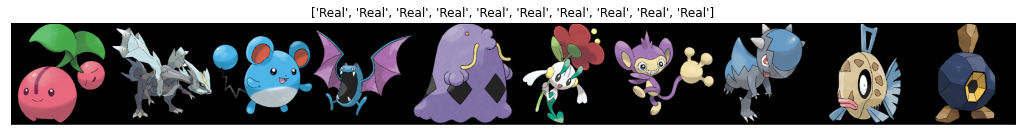

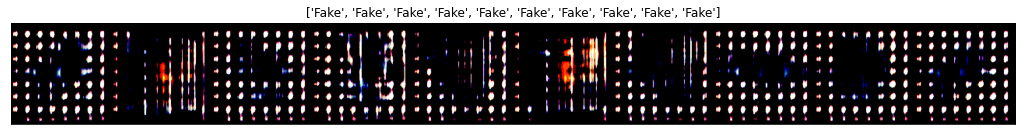

Beginning Epoch 11


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]


Epoch [11/50] - Current Training Time: 551.90 seconds
loss of discriminator D: 0.436
loss of generator G: 1.305
Beginning Epoch 12


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [12/50] - Current Training Time: 602.01 seconds
loss of discriminator D: 0.431
loss of generator G: 1.302
Beginning Epoch 13


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [13/50] - Current Training Time: 652.16 seconds
loss of discriminator D: 0.438
loss of generator G: 1.245
Beginning Epoch 14


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [14/50] - Current Training Time: 702.31 seconds
loss of discriminator D: 0.446
loss of generator G: 1.197
Beginning Epoch 15


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [15/50] - Current Training Time: 752.25 seconds
loss of discriminator D: 0.456
loss of generator G: 1.173
Beginning Epoch 16


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [16/50] - Current Training Time: 802.36 seconds
loss of discriminator D: 0.457
loss of generator G: 1.137
Beginning Epoch 17


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [17/50] - Current Training Time: 852.50 seconds
loss of discriminator D: 0.457
loss of generator G: 1.104
Beginning Epoch 18


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [18/50] - Current Training Time: 902.60 seconds
loss of discriminator D: 0.456
loss of generator G: 1.088
Beginning Epoch 19


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [19/50] - Current Training Time: 952.70 seconds
loss of discriminator D: 0.456
loss of generator G: 1.072
Beginning Epoch 20


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]

Epoch [20/50] - Current Training Time: 1002.83 seconds
loss of discriminator D: 0.458
loss of generator G: 1.061


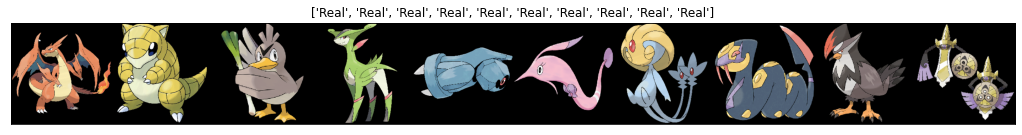

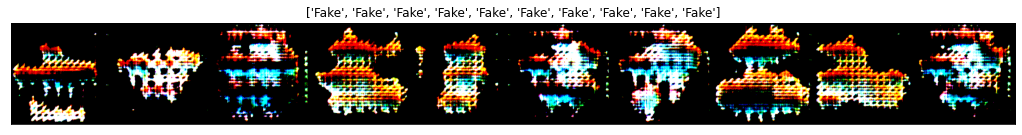

Beginning Epoch 21


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [21/50] - Current Training Time: 1053.66 seconds
loss of discriminator D: 0.458
loss of generator G: 1.045
Beginning Epoch 22


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [22/50] - Current Training Time: 1103.79 seconds
loss of discriminator D: 0.454
loss of generator G: 1.034
Beginning Epoch 23


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [23/50] - Current Training Time: 1153.91 seconds
loss of discriminator D: 0.451
loss of generator G: 1.033
Beginning Epoch 24


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [24/50] - Current Training Time: 1204.05 seconds
loss of discriminator D: 0.456
loss of generator G: 1.019
Beginning Epoch 25


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [25/50] - Current Training Time: 1254.19 seconds
loss of discriminator D: 0.458
loss of generator G: 1.007
Beginning Epoch 26


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [26/50] - Current Training Time: 1304.35 seconds
loss of discriminator D: 0.459
loss of generator G: 0.996
Beginning Epoch 27


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [27/50] - Current Training Time: 1354.51 seconds
loss of discriminator D: 0.456
loss of generator G: 0.986
Beginning Epoch 28


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [28/50] - Current Training Time: 1404.63 seconds
loss of discriminator D: 0.444
loss of generator G: 0.996
Beginning Epoch 29


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [29/50] - Current Training Time: 1454.76 seconds
loss of discriminator D: 0.447
loss of generator G: 0.990
Beginning Epoch 30


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]

Epoch [30/50] - Current Training Time: 1504.91 seconds
loss of discriminator D: 0.449
loss of generator G: 0.979


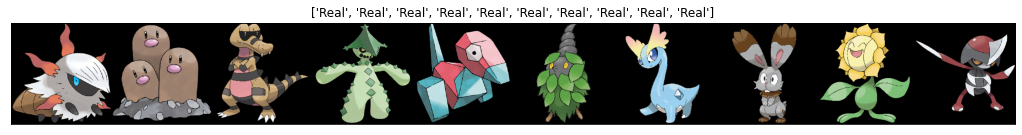

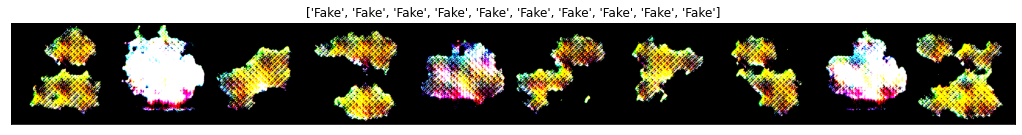

Beginning Epoch 31


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [31/50] - Current Training Time: 1555.57 seconds
loss of discriminator D: 0.451
loss of generator G: 0.966
Beginning Epoch 32


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]


Epoch [32/50] - Current Training Time: 1605.59 seconds
loss of discriminator D: 0.453
loss of generator G: 0.960
Beginning Epoch 33


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [33/50] - Current Training Time: 1655.75 seconds
loss of discriminator D: 0.453
loss of generator G: 0.960
Beginning Epoch 34


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [34/50] - Current Training Time: 1705.89 seconds
loss of discriminator D: 0.455
loss of generator G: 0.952
Beginning Epoch 35


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [35/50] - Current Training Time: 1756.07 seconds
loss of discriminator D: 0.457
loss of generator G: 0.946
Beginning Epoch 36


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [36/50] - Current Training Time: 1806.21 seconds
loss of discriminator D: 0.457
loss of generator G: 0.942
Beginning Epoch 37


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [37/50] - Current Training Time: 1856.37 seconds
loss of discriminator D: 0.458
loss of generator G: 0.941
Beginning Epoch 38


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [38/50] - Current Training Time: 1906.51 seconds
loss of discriminator D: 0.455
loss of generator G: 0.939
Beginning Epoch 39


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [39/50] - Current Training Time: 1956.71 seconds
loss of discriminator D: 0.457
loss of generator G: 0.931
Beginning Epoch 40


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]

Epoch [40/50] - Current Training Time: 2006.92 seconds
loss of discriminator D: 0.451
loss of generator G: 0.927


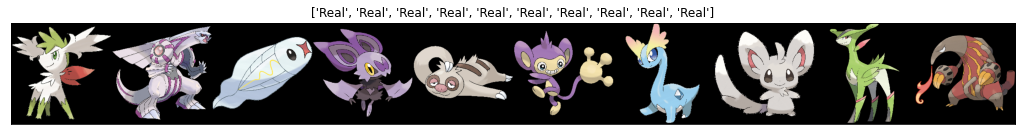

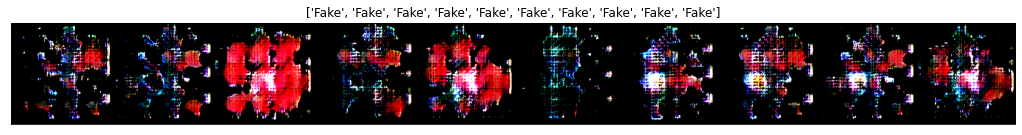

Beginning Epoch 41


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [41/50] - Current Training Time: 2057.74 seconds
loss of discriminator D: 0.448
loss of generator G: 0.926
Beginning Epoch 42


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]


Epoch [42/50] - Current Training Time: 2107.71 seconds
loss of discriminator D: 0.448
loss of generator G: 0.919
Beginning Epoch 43


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [43/50] - Current Training Time: 2157.86 seconds
loss of discriminator D: 0.448
loss of generator G: 0.913
Beginning Epoch 44


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [44/50] - Current Training Time: 2207.97 seconds
loss of discriminator D: 0.448
loss of generator G: 0.908
Beginning Epoch 45


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [45/50] - Current Training Time: 2258.08 seconds
loss of discriminator D: 0.447
loss of generator G: 0.903
Beginning Epoch 46


100%|██████████| 164/164 [00:50<00:00,  3.28it/s]


Epoch [46/50] - Current Training Time: 2308.16 seconds
loss of discriminator D: 0.446
loss of generator G: 0.898
Beginning Epoch 47


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [47/50] - Current Training Time: 2358.30 seconds
loss of discriminator D: 0.446
loss of generator G: 0.887
Beginning Epoch 48


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [48/50] - Current Training Time: 2408.49 seconds
loss of discriminator D: 0.445
loss of generator G: 0.881
Beginning Epoch 49


100%|██████████| 164/164 [00:50<00:00,  3.27it/s]


Epoch [49/50] - Current Training Time: 2458.72 seconds
loss of discriminator D: 0.445
loss of generator G: 0.877
Beginning Epoch 50


100%|██████████| 164/164 [00:49<00:00,  3.28it/s]

Epoch [50/50] - Current Training Time: 2508.72 seconds
loss of discriminator D: 0.444
loss of generator G: 0.872


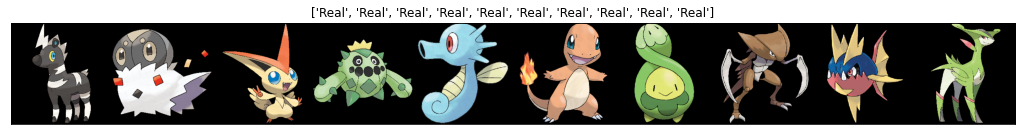

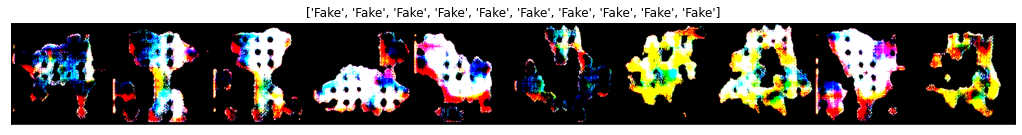

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)
gen.weight_init(mean=0.0, std=0.01)
disc.weight_init(mean=0.0, std=0.01)
gen.train()
disc.train()

num_epochs = 50
optimizer = "ADAGRAD"
loss_func = "BCE"

d_loss, g_loss = train(gen, disc, optimizer, loss_func, learning_rate=0.003, num_epochs=num_epochs)
torch.save(gen.state_dict(), 'gen_test4.pth')

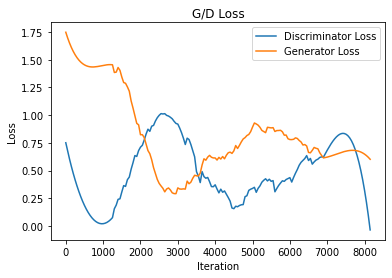

In [ ]:
x = np.arange(0,num_epochs*(dataset_size/batch_size),50)

plt.figure()

# Smooth out the data
d_y = savgol_filter(torch.tensor(d_loss, device='cpu')[x], 51, 3)
g_y = savgol_filter(torch.tensor(g_loss, device='cpu')[x], 51, 3)

plt.plot(x, d_y)
plt.plot(x, g_y)

plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.xticks(np.arange(0,num_epochs*(dataset_size/batch_size),1000))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('G/D Loss')
plt.show()

*Show Some Generated Pokemon!*

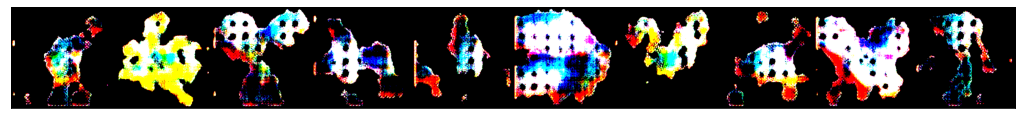

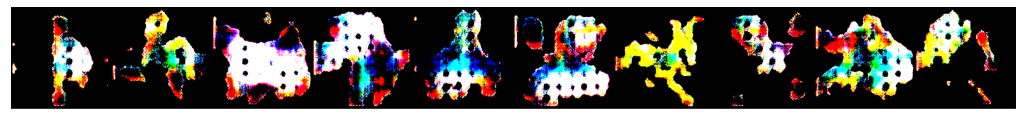

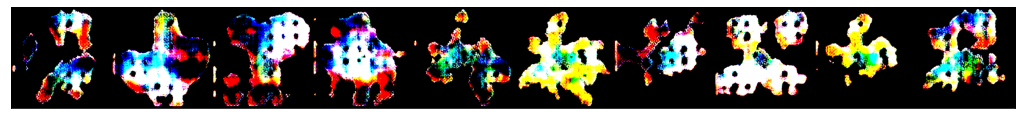

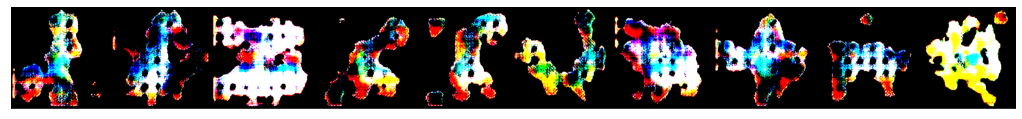

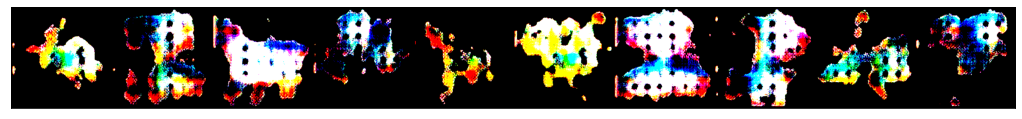

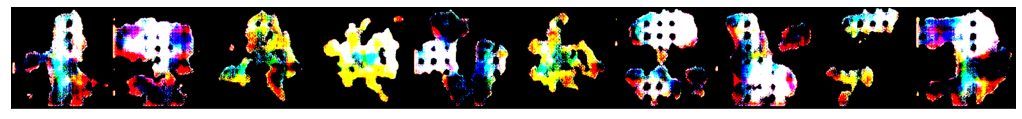

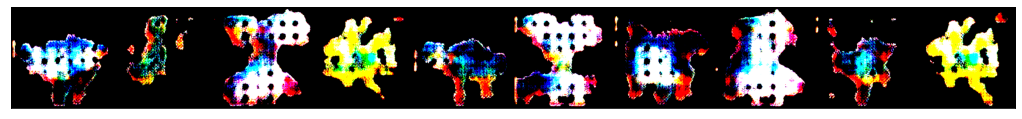

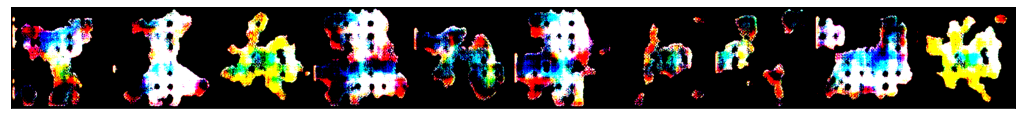

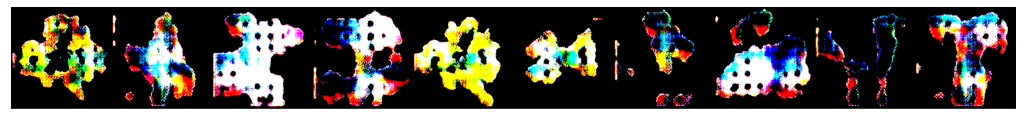

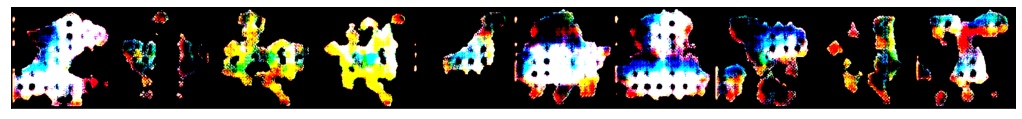

In [ ]:
for i in range(10):
  seed = torch.randn(batch_size, seed_size, 1, 1, device=device)
  fakemon = gen(seed)
  fakemon = denormalize(fakemon.cpu())
  fakemon_grid = torchvision.utils.make_grid(fakemon, nrow=10).cpu().numpy().transpose((1, 2, 0))
  fig, ax = plt.subplots(1, figsize=(18,18))
  ax.imshow(fakemon_grid)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()


In [ ]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

notebookpath = '/content/drive/MyDrive/Pokemon_Synthesis_maxernst.ipynb'

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

MessageError: ignored